In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# =============================================================================
# CONSTANTS & PATHS
# =============================================================================

# Input Files
TERMINAL_HEADWAYS_FILE = "../data/target_terminal_headways.csv"
TOPOLOGY_HEADWAY_FILE = "../data/headway_matrix_topology.npy"

# Output Files
OUTPUT_SCHEDULE_FILE = "../data/schedule_matrix_4terminal.npy"

# Configuration
TIME_BIN_SIZE_MIN = 1

# -----------------------------------------------------------------------------
# Route Variant Definitions (Trip UID Suffix Logic)
# -----------------------------------------------------------------------------
# Classification logic for the 4 channels based on trip_uid patterns
# Validated against trips.txt headsigns

# 1. Inwood-207 St (Northbound) - Headsign "Inwood-207 St"
INWOOD_VARIANTS = ['N04R', 'N09R', 'N54R', 'N55R', 'N65R']

# 2. Lefferts Blvd (Southbound) - Headsign "Ozone Park-Lefferts Blvd"
LEFFERTS_VARIANTS = ['S05R', 'S37R', 'S43R', 'S57R', 'S70R']

# 3. Far Rockaway (Southbound) - Headsign "Far Rockaway-Mott Av"
FAR_ROCKAWAY_VARIANTS = ['S16R', 'S53R', 'S56R', 'S58R', 'S74R']

# 4. Rockaway Park (Southbound) - Headsign "Rockaway Park-Beach 116 St"
ROCKAWAY_PARK_VARIANTS = ['S78R', 'S87R']

# Note: Short turns (Euclid, 168 St, Dyckman) are excluded unless they reach terminal blocks
# These IDs cover ~99% of terminal-bound traffic.

In [2]:
# 1. Load and Parse Terminal Headways

df = pd.read_csv(TERMINAL_HEADWAYS_FILE)

# GTFS uses "24:xx" for times after midnight (e.g., 25:00 = 1 AM next day)
# We need to fix this before parsing.
def fix_gtfs_time_strings(dt_str):
    try:
        # Expected format: "YYYY-MM-DD HH:MM:SS"
        date_part, time_part = dt_str.strip().split(' ')
        h, m, s = map(int, time_part.split(':'))
        
        offset_days = 0
        if h >= 24:
            offset_days = h // 24
            h = h % 24
        
        new_time_str = f"{h:02d}:{m:02d}:{s:02d}"
        return pd.to_datetime(f"{date_part} {new_time_str}") + pd.Timedelta(days=offset_days)
    except Exception:
        # Fallback for weird formats or NaNs
        return pd.NaT

print("Parsing timestamps with >=24h handling...")
# Fix: The input CSV has 'service_date' and 'departure_time' in separate columns
# We must combine them first to create the full datetime string for our parser
df['full_time_str'] = df['service_date'].astype(str) + ' ' + df['departure_time'].astype(str)
df['departure_dt'] = df['full_time_str'].apply(fix_gtfs_time_strings)

# Fix: Column name is 'trip_id', not 'trip_uid'
# Extract route variant from trip_id (e.g., "..._A..S58R" → "S58R")
df['route_variant'] = df['trip_id'].str.extract(r'A\.\.(\w+)')[0]

print(f"Total records: {len(df):,}")
print(f"\nRoute variant distribution:")
print(df['route_variant'].value_counts().head(15))

Parsing timestamps with >=24h handling...
Total records: 64,521

Route variant distribution:
route_variant
N54R    12030
S58R    11245
S57R    11217
N55R    10616
S74R     3916
N09R     3811
S43R     2734
N43R     2734
N04R     1024
S05R      972
S37R      605
N65R      524
S87R      524
N85R      393
N82R      262
Name: count, dtype: int64


In [3]:
# 2. Classify Each Trip by Terminal

def classify_terminal(variant):
    """Map route variant to terminal channel index."""
    if variant in INWOOD_VARIANTS:
        return 0  # Inwood
    elif variant in LEFFERTS_VARIANTS:
        return 1  # Lefferts
    elif variant in FAR_ROCKAWAY_VARIANTS:
        return 2  # Far Rockaway
    elif variant in ROCKAWAY_PARK_VARIANTS:
        return 3  # Rockaway Park
    else:
        # Unknown variant - classify by direction
        return None

df['terminal_idx'] = df['route_variant'].apply(classify_terminal)

# Handle unknown variants
unknown = df[df['terminal_idx'].isna()]
if len(unknown) > 0:
    print(f"Unknown variants ({len(unknown)} records):")
    print(unknown['route_variant'].value_counts())
    
    # Fallback: assign by direction
    df.loc[(df['terminal_idx'].isna()) & (df['direction_id'] == 0), 'terminal_idx'] = 0
    df.loc[(df['terminal_idx'].isna()) & (df['direction_id'] == 1), 'terminal_idx'] = 2  # Default to Far Rockaway

df['terminal_idx'] = df['terminal_idx'].astype(int)

print(f"\nTerminal classification:")
terminal_names = ['Inwood', 'Lefferts', 'Far Rockaway', 'Rockaway Park']
for idx in range(4):
    count = (df['terminal_idx'] == idx).sum()
    print(f"  {idx}: {terminal_names[idx]:20} - {count:,} records ({count/len(df)*100:.1f}%)")

Unknown variants (4255 records):
route_variant
N43R    2734
N85R     393
N82R     262
S51R     262
N37R     211
N60R     131
N18R     131
N58R     131
Name: count, dtype: int64

Terminal classification:
  0: Inwood               - 31,998 records (49.6%)
  1: Lefferts             - 15,790 records (24.5%)
  2: Far Rockaway         - 16,078 records (24.9%)
  3: Rockaway Park        - 655 records (1.0%)


In [4]:
# 3. Get Time Index from Topology Headway Matrix

# Load topology matrix to get dimensions
headway_topo = np.load(TOPOLOGY_HEADWAY_FILE)
num_times = headway_topo.shape[0]
print(f"Topology matrix shape: {headway_topo.shape}")
print(f"Number of timesteps: {num_times:,}")

# Infer time range from observed headways
time_start = df['departure_dt'].min().floor('min')
time_end = df['departure_dt'].max().ceil('min')
print(f"\nObserved headways time range: {time_start} to {time_end}")

# Create time index matching topology (assume same range)
# The topology notebook used the intersection of all branches
time_index = pd.date_range(start=time_start, periods=num_times, freq=f'{TIME_BIN_SIZE_MIN}min')
print(f"Time index: {time_index[0]} to {time_index[-1]}")

Topology matrix shape: (263906, 75, 2, 1)
Number of timesteps: 263,906

Observed headways time range: 2025-06-06 00:11:00 to 2025-12-07 02:02:00
Time index: 2025-06-06 00:11:00 to 2025-12-06 06:36:00


In [5]:
# 4. Pivot and Resample by Terminal

# Fix: Use 'scheduled_headway_min' if 'observed_headway_min' is missing
# (Based on typical GTFS data or the user's CSV inspection)
value_col = 'observed_headway_min'
if value_col not in df.columns:
    print(f"Warning: '{value_col}' not found. Using 'scheduled_headway_min'.")
    value_col = 'scheduled_headway_min'

# Create pivot table: time x terminal
pivot = df.pivot_table(
    index='departure_dt',
    columns='terminal_idx',
    values=value_col,
    aggfunc='mean'
)

# Ensure all 4 terminals exist
for t in range(4):
    if t not in pivot.columns:
        pivot[t] = np.nan

pivot = pivot[[0, 1, 2, 3]]  # Order columns

# Resample to 1-minute and forward fill
pivot_resampled = pivot.resample(f'{TIME_BIN_SIZE_MIN}min').mean()
pivot_filled = pivot_resampled.ffill(limit=30).fillna(0)

print(f"Pivot shape after resampling: {pivot_filled.shape}")
print(f"\nSample data:")
print(pivot_filled.head(10))

Pivot shape after resampling: (265054, 4)

Sample data:
terminal_idx           0    1     2    3
departure_dt                            
2025-06-06 00:29:00  0.0  0.0  18.0  0.0
2025-06-06 00:30:00  0.0  0.0  18.0  0.0
2025-06-06 00:31:00  0.0  0.0  18.0  0.0
2025-06-06 00:32:00  0.0  0.0  18.0  0.0
2025-06-06 00:33:00  0.0  0.0  18.0  0.0
2025-06-06 00:34:00  0.0  0.0  18.0  0.0
2025-06-06 00:35:00  0.0  0.0  18.0  0.0
2025-06-06 00:36:00  0.0  0.0  18.0  0.0
2025-06-06 00:37:00  0.0  0.0  18.0  0.0
2025-06-06 00:38:00  0.0  0.0  18.0  0.0


In [6]:
# 5. Align to Topology Time Index

# Reindex to match topology matrix time range
aligned = pivot_filled.reindex(time_index).ffill().fillna(0)

print(f"Aligned shape: {aligned.shape}")
print(f"Expected: ({num_times}, 4)")

# Verify alignment
assert len(aligned) == num_times, f"Time mismatch: {len(aligned)} vs {num_times}"

Aligned shape: (263906, 4)
Expected: (263906, 4)


In [7]:
# 6. Create Schedule Matrix

# Shape: (T, 4, 1) - 4 terminal channels
schedule_matrix = aligned.values.reshape(num_times, 4, 1)

print(f"Schedule matrix shape: {schedule_matrix.shape}")
print(f"")
print(f"Per-terminal statistics:")
for idx, name in enumerate(terminal_names):
    channel = schedule_matrix[:, idx, 0]
    non_zero = channel[channel > 0]
    print(f"  {name}:")
    print(f"    Zero fraction: {(channel == 0).sum() / len(channel):.1%}")
    if len(non_zero) > 0:
        print(f"    Mean headway: {non_zero.mean():.2f} min")
        print(f"    Max headway: {non_zero.max():.2f} min")

Schedule matrix shape: (263906, 4, 1)

Per-terminal statistics:
  Inwood:
    Zero fraction: 0.0%
    Mean headway: 7.36 min
    Max headway: 24.00 min
  Lefferts:
    Zero fraction: 4.3%
    Mean headway: 8.17 min
    Max headway: 63.50 min
  Far Rockaway:
    Zero fraction: 0.3%
    Mean headway: 9.53 min
    Max headway: 20.00 min
  Rockaway Park:
    Zero fraction: 94.7%
    Mean headway: 3.28 min
    Max headway: 6.50 min


In [8]:
# 7. Save Output

np.save(OUTPUT_SCHEDULE_FILE, schedule_matrix)

print(f"✅ Saved 4-terminal schedule matrix!")
print(f"")
print(f"File: {OUTPUT_SCHEDULE_FILE}")
print(f"Shape: {schedule_matrix.shape}")
print(f"")
print(f"Channels:")
print(f"  0: Inwood-207 St (Northbound trains)")
print(f"  1: Lefferts Blvd (Southbound Lefferts)")
print(f"  2: Far Rockaway (Southbound Rockaway)")
print(f"  3: Rockaway Park (Southbound Rockaway Park)")
print(f"")
print(f"="*60)
print(f"To use this, update model to accept schedule shape (T, 4, 1)")
print(f"Or merge channels 2+3 for (T, 3, 1) if Rockaway Park is rare")
print(f"="*60)

✅ Saved 4-terminal schedule matrix!

File: ../data/schedule_matrix_4terminal.npy
Shape: (263906, 4, 1)

Channels:
  0: Inwood-207 St (Northbound trains)
  1: Lefferts Blvd (Southbound Lefferts)
  2: Far Rockaway (Southbound Rockaway)
  3: Rockaway Park (Southbound Rockaway Park)

To use this, update model to accept schedule shape (T, 4, 1)
Or merge channels 2+3 for (T, 3, 1) if Rockaway Park is rare


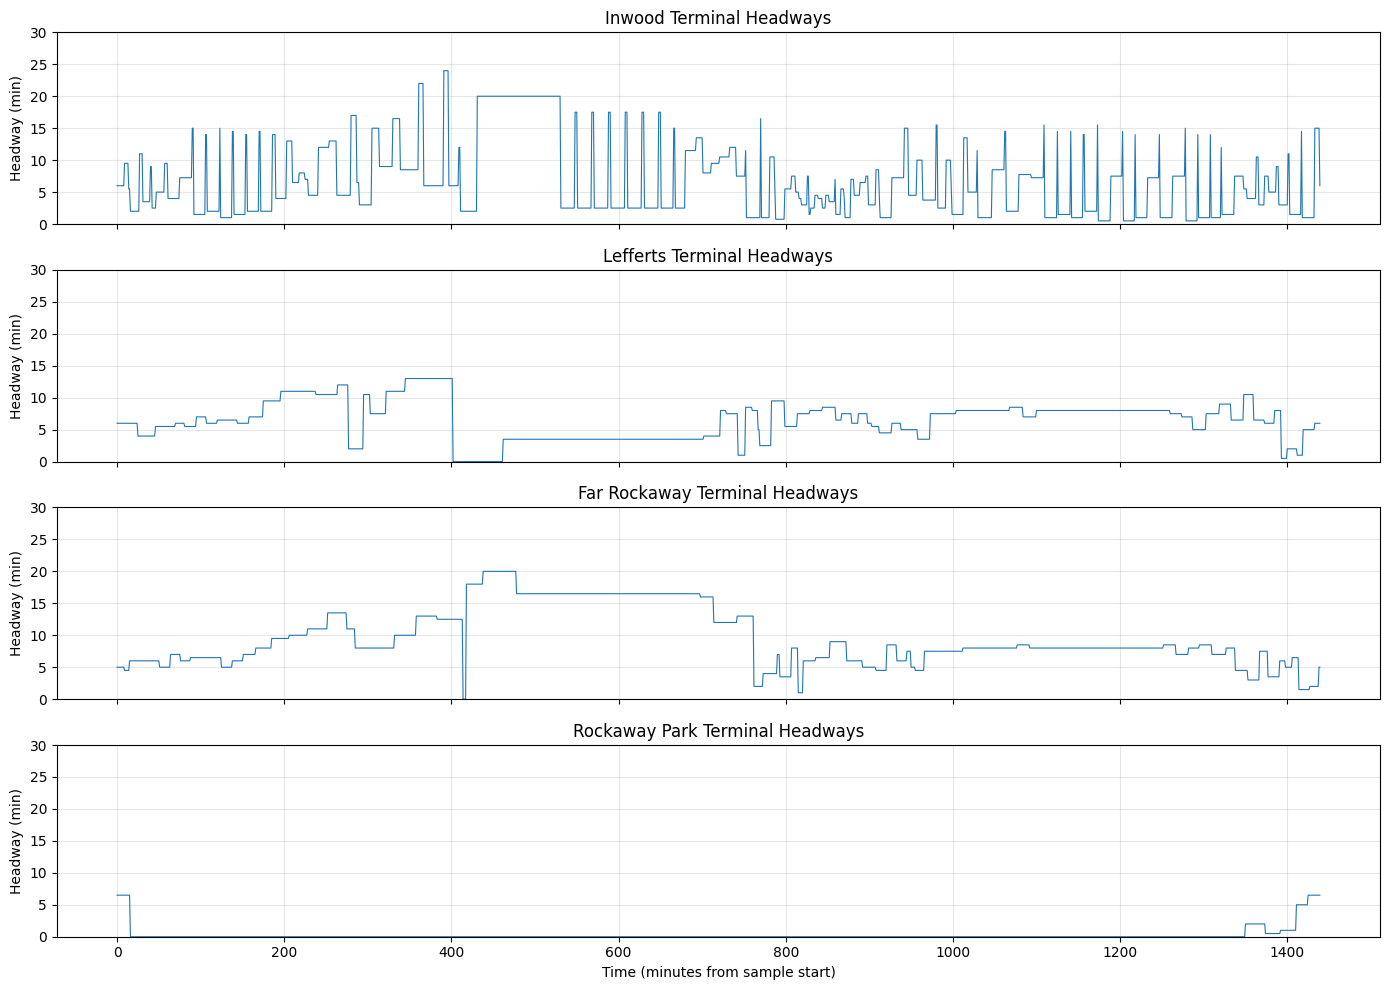

Saved visualization to ../images/terminal_headways_4channel.png


In [9]:
# 8. Visualization: Terminal Headway Patterns

import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# Sample 24 hours
t_start = 50000
t_len = 1440  # 24 hours

for idx, (ax, name) in enumerate(zip(axes, terminal_names)):
    data = schedule_matrix[t_start:t_start+t_len, idx, 0]
    ax.plot(data, linewidth=0.8)
    ax.set_ylabel('Headway (min)')
    ax.set_title(f'{name} Terminal Headways')
    ax.set_ylim(0, 30)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Time (minutes from sample start)')
plt.tight_layout()
plt.savefig('../images/terminal_headways_4channel.png', dpi=150)
plt.show()

print("Saved visualization to ../images/terminal_headways_4channel.png")

In [ ]:
# 9. Optional: Create 3-Terminal Version (merge Rockaway branches)

# Rockaway Park service is infrequent - merge with Far Rockaway
schedule_3term = np.zeros((num_times, 3, 1))
schedule_3term[:, 0, :] = schedule_matrix[:, 0, :]  # Inwood
schedule_3term[:, 1, :] = schedule_matrix[:, 1, :]  # Lefferts
# Merge Far Rockaway + Rockaway Park (take min headway = next train)
schedule_3term[:, 2, :] = np.minimum(
    np.where(schedule_matrix[:, 2, :] > 0, schedule_matrix[:, 2, :], 999),
    np.where(schedule_matrix[:, 3, :] > 0, schedule_matrix[:, 3, :], 999)
)
schedule_3term[:, 2, :] = np.where(schedule_3term[:, 2, :] == 999, 0, schedule_3term[:, 2, :])

np.save('../data/schedule_matrix_3terminal.npy', schedule_3term)

print(f"✅ Also saved 3-terminal version (Rockaway branches merged)")
print(f"File: ../data/schedule_matrix_3terminal.npy")
print(f"Shape: {schedule_3term.shape}")
print(f"")
print(f"Channels:")
print(f"  0: Inwood-207 St")
print(f"  1: Lefferts Blvd")
print(f"  2: Rockaway (Far Rockaway + Rockaway Park)")